# Notebook for CCI-derived metabolism from scRNA-Seq using MEBOCOST in Fetal Stem Cells
- **Developed by:** Anna Maguza
- **Place:** Wuerzburg Institute for System Immunology
- **Date:** 16th November 2023

### Import packages

In [1]:
import os,sys
import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from mebocost import mebocost

### Set up the cells

In [2]:
%matplotlib inline

In [4]:
sc.settings.verbosity = 3
sc.logging.print_versions()

sc.settings.set_figure_params(frameon=False, dpi=100)

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.9.2
scanpy      1.8.2
sinfo       0.3.4
-----
PIL                         10.1.0
adjustText                  NA
anyio                       NA
arrow                       1.3.0
asttokens                   NA
attr                        23.1.0
attrs                       23.1.0
babel                       2.13.1
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
brotli                      1.1.0
certifi                     2023.07.22
cffi         

In [5]:
import warnings

warnings.simplefilter("ignore", category=UserWarning)

In [8]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

### Data Upload

In [6]:
input_path = '/home/amaguza/data/Processed_data/Gut_data/Stem_cells/Fetal_healthy_stem_cells_leiden.h5ad'
adata = sc.read_h5ad(input_path)

In [7]:
# Extract the raw counts
adata = adata.raw.to_adata()
adata

AnnData object with n_obs × n_vars = 7817 × 19868
    obs: 'Sample_ID', 'Cell Type', 'Study_name', 'Donor_ID', 'Diagnosis', 'Age', 'Region code', 'Fraction', 'Sex', 'Library_Preparation_Protocol', 'batch', 'Age_group', 'Location', 'Cell States', 'Cell States GCA', 'Chem', 'Layer', 'Cell States Kong', 'dataset', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo', 'Cell_ID', '_scvi_batch', '_scvi_labels', 'n_genes', 'n_counts', 'leiden', 'cluster'
    var: 'feature_types-0-0-0', 'gene_name-1-0-0', 'gene_id-0-0', 'GENE-1-0', 'n_counts', 'n_cells'
    uns: 'Age_colors', 'Age_group_colors', 'Donor_ID_colors', 'Library_Preparation_Protocol_colors', 'Sex_colors', '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'rank_genes_groups', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    obsp: 'connectivities', 'distances'

In [9]:
X_is_raw(adata)

True

### Infer metabolic communications

* The mebocost.conf file needs to be provided. It is in the original repo and after installation it will have the correct paths and should work out of the box. You could provide the full path to the file, or create a symlink.

In [11]:
mebo_obj = mebocost.create_obj(
                        adata = adata,
                        group_col = ['cluster'],
                        met_est = 'mebocost',
                        config_path = '/home/amaguza/MEBOCOST/mebocost.conf',
                        exp_mat = None,
                        cell_ann = None,
                        species = 'human',
                        met_pred = None,
                        met_enzyme = None,
                        met_sensor = None,
                        met_ann = None,
                        scFEA_ann = None,
                        compass_met_ann = None,
                        compass_rxn_ann = None,
                        gene_network = None,
                        gmt_path = None,
                        cutoff_exp = 'auto', ## automated cutoff to exclude lowly ranked 25% sensors across all cells
                        cutoff_met = 'auto', ## automated cutoff to exclude lowly ranked 25% metabolites across all cells
                        cutoff_prop = 0.25, ## at lease 25% of cells should be expressed the sensor or present the metabolite in the cell group (specified by group_col)
                        sensor_type = ['Receptor', 'Transporter', 'Nuclear Receptor'],
                        thread = 4
                        )

[November 16, 2023 10:23:23]: We get expression data with 19868 genes and 7817 cells.
[November 16, 2023 10:23:23]: Data Preparation Done in 0.0592 seconds


### Estimate metabolite presence

* If you just want the table of metabolic activity, you can stop here and export it as a CSV file.

In [12]:
mebo_obj._load_config_()
mebo_obj.estimator()

[November 16, 2023 10:23:29]: Load config and read data based on given species [human].
[November 16, 2023 10:23:30]: Estimtate metabolite level using mebocost


In [13]:
met_mat = pd.DataFrame(mebo_obj.met_mat.toarray(),
                      index = mebo_obj.met_mat_indexer,
                      columns = mebo_obj.met_mat_columns)
met_mat.head()

,AAACCTGCATCTACGA-1-Human_colon_16S8159182,AAACGGGTCGGCGCAT-1-Human_colon_16S8159182,AAACGGGTCTTACCGC-1-Human_colon_16S8159182,AAAGATGAGATATACG-1-Human_colon_16S8159182,AAAGATGGTCTCCATC-1-Human_colon_16S8159182,AAAGATGTCACCTTAT-1-Human_colon_16S8159182,AAAGCAAGTGACCAAG-1-Human_colon_16S8159182,AAAGCAATCCCTAACC-1-Human_colon_16S8159182,AAAGCAATCGACGGAA-1-Human_colon_16S8159182,AAAGTAGCAAGCCATT-1-Human_colon_16S8159182,...,CCAATCCCACCACCAG-1-4918STDY7718977,CCAGCGACATCTGGTA-1-4918STDY7718977,CCGTACTCACGTAAGG-1-4918STDY7718977,CCTTCGATCCACGTGG-1-4918STDY7718977,CGTAGCGTCGCCAAAT-1-4918STDY7718977,CTAGCCTAGTGAACGC-1-4918STDY7718977,CTCGTACGTCAAACTC-1-4918STDY7718977,CTGTGCTAGGATGTAT-1-4918STDY7718977,GATCGTAAGTAGGTGC-1-4918STDY7718977,TCAGCAAAGTGCGATG-1-4918STDY7718977
HMDB0003450,0.000000,0.000000,0.500000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
HMDB0003948,0.571429,0.142857,1.142857,0.857143,0.857143,0.142857,1.142857,0.714286,1.000000,1.000000,...,0.0,0.571429,0.428571,0.142857,0.142857,0.428571,0.0,0.857143,0.285714,0.142857
HMDB0003712,0.444444,0.111111,1.000000,0.888889,0.777778,0.111111,1.222222,0.666667,0.888889,0.777778,...,0.0,0.444444,0.555556,0.111111,0.111111,0.555556,0.0,0.666667,0.222222,0.111111
HMDB0003945,0.625000,0.125000,1.000000,0.875000,0.750000,0.125000,1.250000,0.625000,1.000000,0.875000,...,0.0,0.625000,0.625000,0.250000,0.125000,0.500000,0.0,0.750000,0.250000,0.375000
HMDB0003949,0.571429,0.142857,1.142857,0.857143,0.857143,0.142857,1.142857,0.714286,1.000000,1.000000,...,0.0,0.571429,0.428571,0.142857,0.142857,0.428571,0.0,0.857143,0.285714,0.142857


### MEBOCOST cell-cell communication inference

In [14]:
commu_res = mebo_obj.infer_commu(
                                n_shuffle = 1000,
                                seed = 1712, 
                                Return = True, 
                                thread = 4,
                                save_permuation = False,
                                min_cell_number = 3
                            )

[November 16, 2023 10:24:32]: Load config and read data based on given species [human].
[November 16, 2023 10:24:34]: Estimtate metabolite level using mebocost
[November 16, 2023 10:24:39]: Infer communications
[November 16, 2023 10:24:39]: Sensor type used ['Transporter', 'Receptor', 'Nuclear Receptor']
[November 16, 2023 10:24:39]: Parameters: {shuffling: 1000 times, random seed: 1712, thread: 4}
[November 16, 2023 10:24:40]: met_sensor: (290, 8)
[November 16, 2023 10:24:40]: avg_exp: (2002, 3) for (gene, cell) of needed
[November 16, 2023 10:24:40]: avg_met: (578, 3) for (metabolite, cell) of needed
[November 16, 2023 10:24:40]: shuffling 1000 times for generating backgroud
[November 16, 2023 10:24:41]: take exp and met avg for shuffling
[November 16, 2023 10:24:45]: thread: 4
[November 16, 2023 10:24:46]: ABCA1 ~ HMDB0006247
[November 16, 2023 10:24:46]: Normalizing Cluster Mean and Calculating Communication Score
[November 16, 2023 10:24:46]: Calculating P-value
[November 16, 2023

In [15]:
print('sensor_exp cutoff: %s'%mebo_obj.cutoff_exp)
print('metabolite_presence cutoff: %s'%mebo_obj.cutoff_met)

sensor_exp cutoff: 1.0
metabolite_presence cutoff: 0.25


In [16]:
# Save results
commu_res.to_csv('/home/amaguza/data/Processed_data/Gut_data/Stem_cells/FetalSC_mebocost/FetalSC_mebocost_results.csv')

### Visualise MEBOCOST prediction

### Showing the detailed communications (sender-receiver vs metabolite-sensor) in a dot map

[November 16, 2023 10:27:51]: plot heatmap for significant result


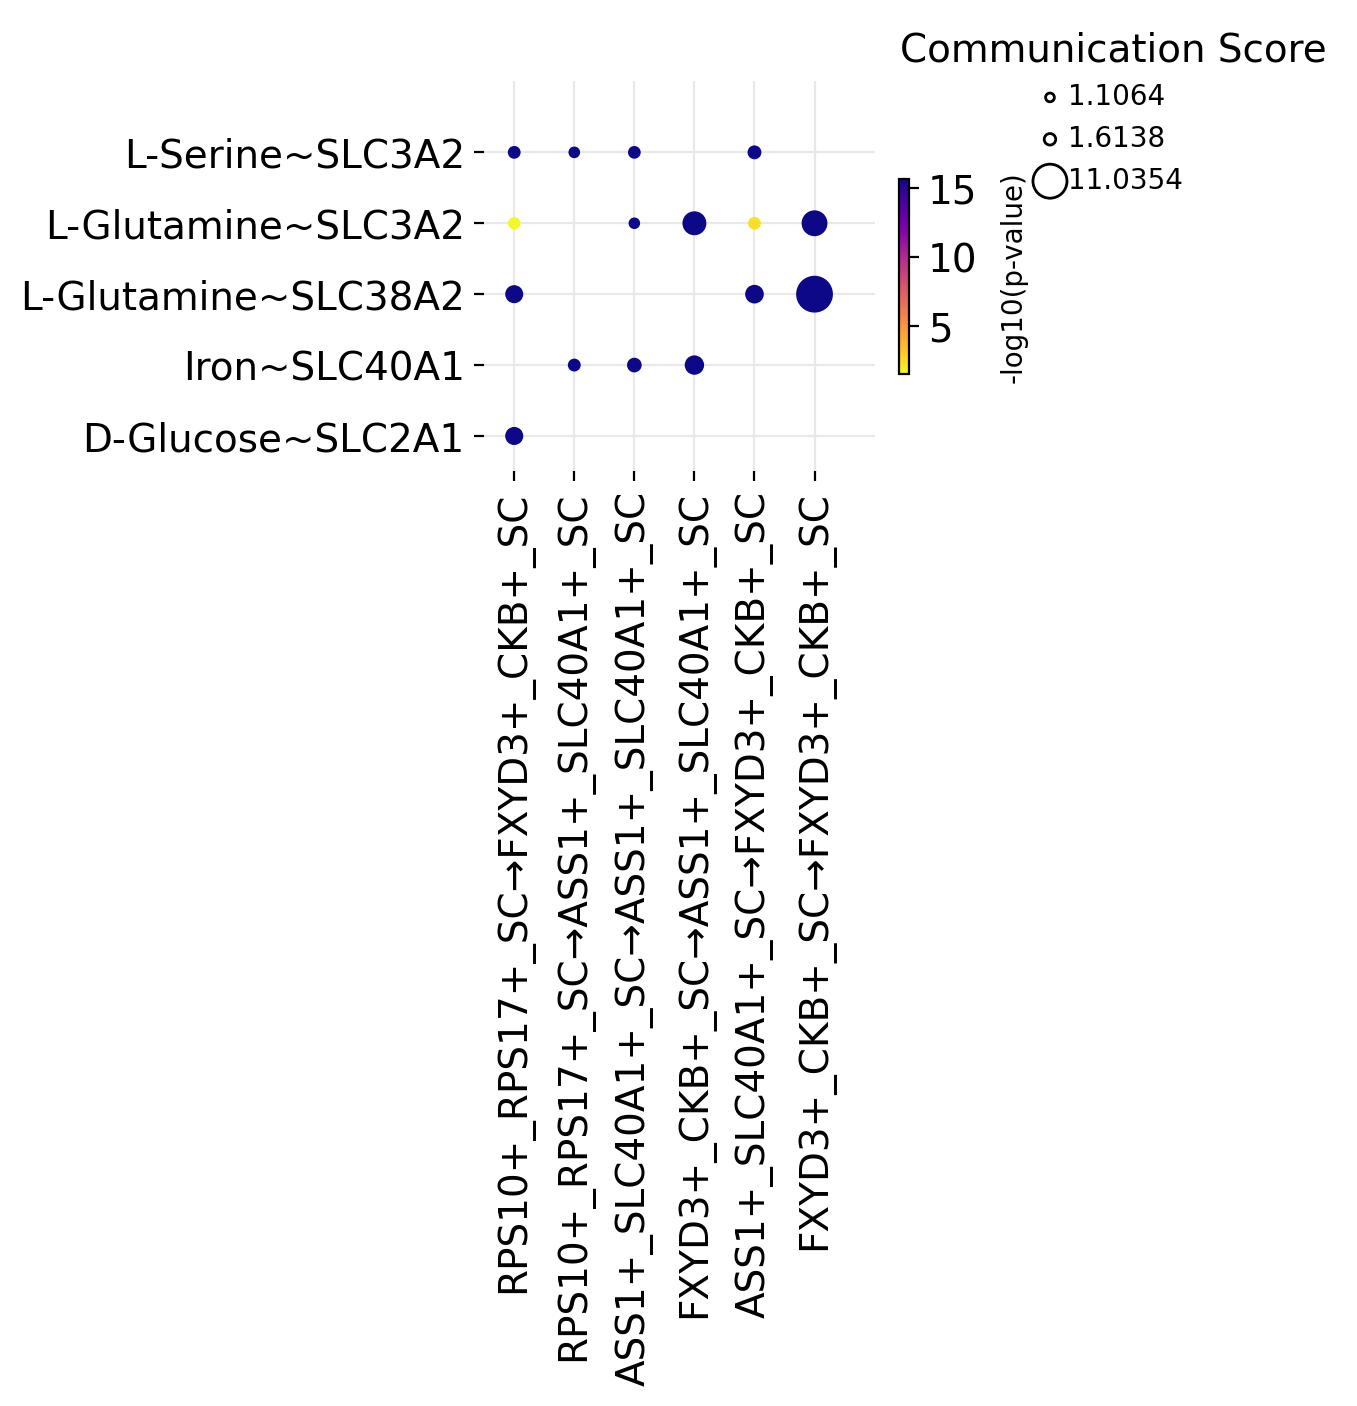

In [17]:
mebo_obj.commu_dotmap(
                sender_focus = [],
                metabolite_focus = [],
                sensor_focus = [],
                receiver_focus = [],
                and_or = 'and',
                pval_method = 'permutation_test_fdr',
                pval_cutoff = 0.05,
                figsize = 'auto',
                cmap = 'plasma_r',
                node_size_norm = (10, 150),
                save = None,
                show_plot = True,
                comm_score_col = 'Commu_Score',
                comm_score_cutoff = 0,
                swap_axis = False,
                return_fig = False
                )

[November 16, 2023 10:29:31]: plot flow plot to show the communications from Sender -> Metabolite -> Sensor -> Receiver


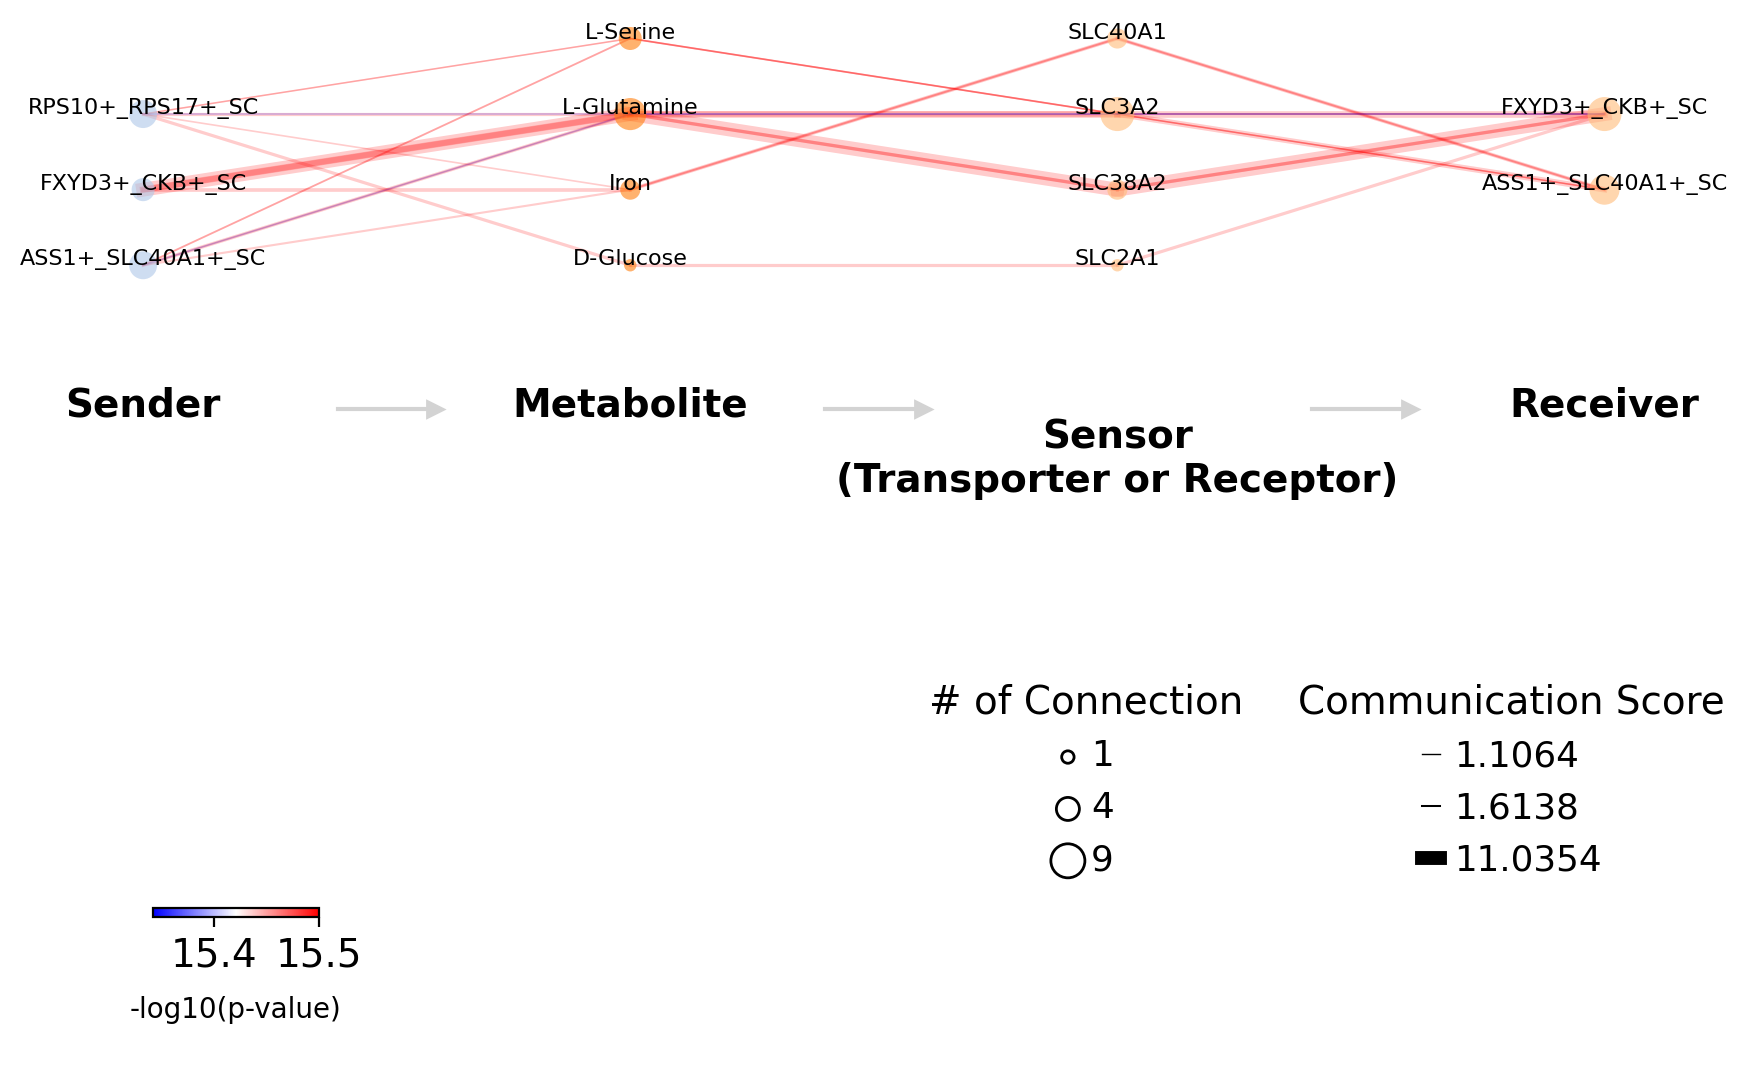

In [18]:
mebo_obj.FlowPlot(
                pval_method = 'permutation_test_fdr',
                pval_cutoff = 0.05,
                sender_focus = [],
                metabolite_focus = [],
                sensor_focus = [],
                receiver_focus = [],
                remove_unrelevant = False,
                and_or = 'and',
                node_label_size = 8,
                node_alpha = 0.6,
                figsize = 'auto',
                node_cmap = 'tab20',
                line_cmap = 'bwr',
                line_vmin = None,
                line_vmax = 15.5,
                node_size_norm = (20, 150),
                linewidth_norm = (0.5, 5),
                save = None,
                show_plot = True,
                comm_score_col = 'Commu_Score',
                comm_score_cutoff = 0,
                text_outline = False,
                return_fig = False
            )

[November 16, 2023 10:29:59]: Warnings: no sensors to plot
[November 16, 2023 10:29:59]: Find metabolites ['L-Glutamine', 'Iron', 'L-Serine', 'D-Glucose'] to plot violin


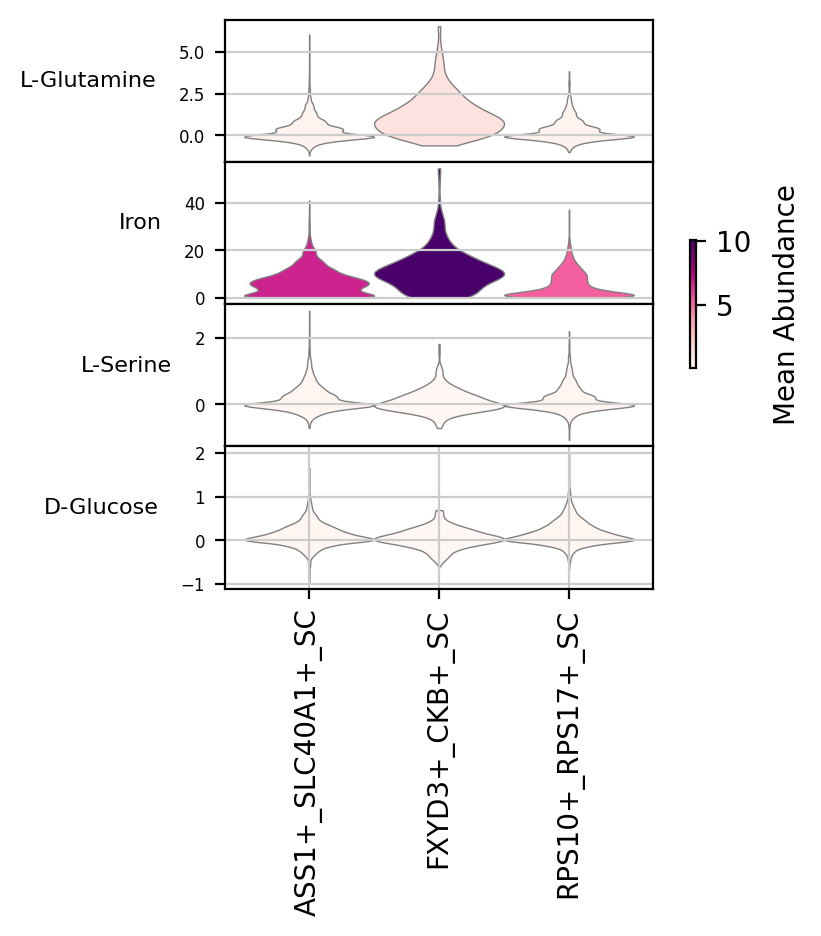

In [19]:
commu_df = mebo_obj.commu_res.copy()
commu_df = mebo_obj.commu_res.copy()
good_met = commu_df[(commu_df['permutation_test_fdr']<=0.05)]['Metabolite_Name'].sort_values().unique()

mebo_obj.violin_plot(
                    sensor_or_met = good_met[:15], ## only top 5 as example
                    cell_focus = [],
                    cmap = 'RdPu',
                    vmin = None,
                    vmax = None,
                    figsize = 'auto',
                    cbar_title = '',
                    save = None,
                    show_plot = True
                    )